In [1]:
import torch
import torchvision
import torch.utils.data as Data
import torch.optim as optim
import random
import numpy as np

from torch import nn
from matplotlib import pyplot as plt

[HAMI-core Msg(8219:139805994032000:libvgpu.c:836)]: Initializing.....


### Pytorch基本操作考察
#### 减法操作
使用𝐓𝐞𝐧𝐬𝐨𝐫初始化一个𝟏×𝟑的矩阵𝑴和一个𝟐×𝟏的矩阵𝑵，对两矩阵进行减法操作(要求实现三种不同的形式)，给出结果并分析三种方式的不同(如果出现报错，分析报错的原因)，同时需要指出在计算过程中发生了什么。

In [2]:
M = torch.tensor([[4, 5, 6]])
N = torch.tensor([[1], [2]])
M, N

(tensor([[4, 5, 6]]),
 tensor([[1],
         [2]]))

In [3]:
M - N

tensor([[3, 4, 5],
        [2, 3, 4]])

In [4]:
torch.sub(M, N)

tensor([[3, 4, 5],
        [2, 3, 4]])

In [5]:
# 非原地操作, 减法操作后返回新矩阵，M不变
M.sub(N), M

(tensor([[3, 4, 5],
         [2, 3, 4]]),
 tensor([[4, 5, 6]]))

In [6]:
# 由于广播机制，计算后的矩阵形状为(2,3)，而 M 为(1,3)，无法进行原地操作，因而报错
M.sub_(N)

RuntimeError: output with shape [1, 3] doesn't match the broadcast shape [2, 3]

#### 矩阵求内积
(1) 利用 𝐓𝐞𝐧𝐬𝐨𝐫 创建两个大小分别𝟑×𝟐和𝟒×𝟐的随机数矩阵𝑷和𝑸，要求服从均值为0，标准差0.01为的正态分布;<br>
(2) 对第二步得到的矩阵 𝑸 进行形状变换得到 𝑸 的转置 𝑸𝑻 ;<br>
(3) 对上述得 到的矩阵 𝑷 和矩阵 𝑸𝑻 求内积

In [9]:
P = torch.normal(mean=0.0, std=0.01, size=(3, 2))
Q = torch.normal(mean=0.0, std=0.01, size=(4, 2))
P, Q

(tensor([[-9.4909e-03, -1.0810e-02],
         [-8.7318e-03,  4.7816e-03],
         [-9.8802e-03,  6.8840e-05]]),
 tensor([[ 0.0051,  0.0162],
         [ 0.0069,  0.0008],
         [ 0.0046, -0.0049],
         [-0.0097, -0.0086]]))

In [10]:
Q_T = Q.T
Q_T

tensor([[ 0.0051,  0.0069,  0.0046, -0.0097],
        [ 0.0162,  0.0008, -0.0049, -0.0086]])

In [11]:
# 相当于矩阵乘积
torch.mm(P, Q_T)

tensor([[-2.2356e-04, -7.3904e-05,  8.9038e-06,  1.8544e-04],
        [ 3.2586e-05, -5.6746e-05, -6.3646e-05,  4.3839e-05],
        [-4.9551e-05, -6.8289e-05, -4.5960e-05,  9.5585e-05]])

#### 梯度计算
给定公式 $𝑦_3 = 𝑦_1 + 𝑦_2 = x^2 + x^3 $，且 $𝑥=1$。利用学习所得到的Tensor的相关知识，求 $𝑦_3$ 对 $x$ 的梯度，即 $\frac {dy_3} {dx}$。<br>
要求在计算过程中，在计算 $𝑥^3$ 时中断梯度的追踪，观察结果并进行原因分析。<br>
提示：可使用 with torch.no_grad()<br>

In [18]:
x = torch.ones(1,requires_grad=True)
y1 = x**2

with torch.no_grad():
    y2 = x**3
    
y3 = y1 + y2
y3.backward()
x.grad

tensor([2.])

In [17]:
x = torch.ones(1,requires_grad=True)
y1 = x**2
y2 = x**3
    
y3 = y1 + y2
y3.backward()
x.grad

tensor([5.])

### 训练集


#### 人工构造的数据集

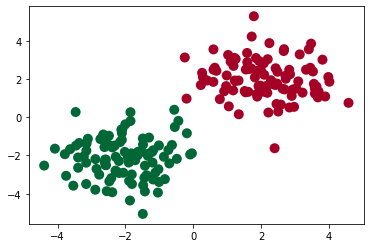

In [3]:
n_data = torch.ones(100, 2)         # 数据的基本形态
x1 = torch.normal(2 * n_data, 1)   # shape=(50, 2)，服从均值为1、标准差为1的正态分布
y1 = torch.zeros(100)               # 类型0 shape=(50, 1)
x2 = torch.normal(-2 * n_data, 1)  # 类型1 shape=(50, 1) 
y2 = torch.ones(100)                # 类型1 shape=(50, 1)

# 注意 x, y 数据的数据形式一定要像下面一样 (torch.cat 是合并数据) 
x_all = torch.cat((x1, x2), 0).type('torch.FloatTensor')
y_all = torch.cat((y1, y2), 0).type('torch.FloatTensor')

# 可视化
plt.scatter(x_all.data.numpy()[:, 0], x_all.data.numpy()[:, 1],
            c=y_all.data.numpy(), s=100, lw=0, cmap='RdYlGn')
plt.show()

In [4]:
def train_test_split(x: torch.Tensor, y: torch.Tensor,
                     shuffle: bool=True, seed=1, test_size=0.3):
    """ 切分数据集 """
    num_samples = x.shape[0]
    indices = list(range(num_samples))

    # 混洗
    if shuffle:
        random.seed(seed)
        random.shuffle(indices)

    # 切分数据集
    num_train = int(num_samples*(1-test_size))

    # 切片
    indices_train = torch.tensor(indices[: num_train])
    indices_test = torch.tensor(indices[num_train:])

    return x.index_select(dim=0, index=indices_train), y.index_select(dim=0, index=indices_train),\
           x.index_select(dim=0, index=indices_test), y.index_select(dim=0, index=indices_test)

def data_iter(x: torch.Tensor, y: torch.Tensor, batch_size: int=8):
    """ 数据集生成器 """

    num_samples = x.shape[0]
    indices = list(range(num_samples))

    # 构造小批次数据集
    for i in range(0, num_samples, batch_size):

        # 选取的该批次内的行索引
        j = torch.tensor(indices[i: min(i+batch_size, num_samples)])

        yield x.index_select(dim=0, index=j), y.index_select(0, j)


# 切分数据集
x_train, y_train, x_test, y_test = train_test_split(x_all, y_all, test_size=0.3)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([140, 2]),
 torch.Size([140]),
 torch.Size([60, 2]),
 torch.Size([60]))

##### 从0实现logistic回归
要求动手从0实现logistic回归(只借助Tensor和Numpy相关的库)在人工构造的数据集上进行训练和测试，<br>
并从loss、训练集以及测试集上的准确率等多个角度对结果进行分析。<br>
(可借助nn.BCELoss或nn.BCEWithLogitsLoss作为损失函数，从零实现二元交叉熵为选作)<br>

In [5]:
def sigmoid(x: torch.Tensor, w: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    """
    激活函数-逻辑斯蒂回归
    x: [batch_size, num_inputs]
    w: [num_inputs, 1]
    b: [1, ]
    :return [batch_size, 1]
    """
    return 1 / (1 + torch.exp(-(torch.mm(x, w) + b)))


def binary_cross_entropy(y_hat: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    """
    损失函数-二元交叉熵
    :param y_hat(one_hot):   预测值 (batch_size, 1)
    :param y_true:           真值  (batch_size)
    :return:
    """
    l =  y_true * torch.log(y_hat) + (1-y_true) * torch.log(1 - y_hat)
    return - l.sum()/y_true.shape[0]

def sgd(*params, lr, batch_size):
    """
    优化器-梯度下降
    :param params:      参数列表
    :param lr:          学习率
    :param batch_size:  批次大小
    :return:
    """
    for param in params:
        # 注意这里更改param时用的param.data
        param.data -= lr * param.grad / batch_size

# 参数配置
num_inputs = x_train.shape[1]
num_samples = x_train.shape[0]
batch_size = 8
num_epochs = 10
lr = 0.5
net = sigmoid
loss = binary_cross_entropy

# 模型训练 w = [w_0, ..., w_n]
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)),
                 dtype=torch.float32,
                 requires_grad=True)
b = torch.zeros(1, dtype=torch.float32, requires_grad=True)

for epoch in range(num_epochs):

    # 读取数据集
    iter_train = data_iter(x_train, y_train, batch_size=batch_size)

    # 一批次的训练数据
    for X, y_true in iter_train:

        # 模型预测值
        y_hat = net(X, w, b)

        # 损失值
        # (batch_size, 1) => (batch_size, )
        y_hat = y_hat.view(y_true.size())
        l = loss(y_hat, y_true)

        # 反向传播
        l.backward()

        # 随机梯度下降
        sgd(w, b, lr=lr, batch_size=batch_size)

        # 梯度置零
        w.grad.data.zero_()
        b.grad.data.zero_()

    y_hat = net(x_train, w, b)
    y_hat = y_hat.view(y_train.size())
    train_l = loss(y_hat, y_train)
    print('epoch %d, loss %f' % (epoch + 1, train_l))

w, b

epoch 1, loss 0.147422
epoch 2, loss 0.090928
epoch 3, loss 0.068785
epoch 4, loss 0.056685
epoch 5, loss 0.048948
epoch 6, loss 0.043523
epoch 7, loss 0.039480
epoch 8, loss 0.036333
epoch 9, loss 0.033803
epoch 10, loss 0.031717


(tensor([[-1.1707],
         [-1.1536]], requires_grad=True),
 tensor([0.0208], requires_grad=True))

In [6]:
# 评估-准确率
def accuracy_count(y_hat: torch.Tensor, y: torch.Tensor):
    mask = y_hat > 0.5
    y_hat[mask] = 1
    y_hat[~mask] = 0
    return (y_hat == y).sum()

iter_test = data_iter(x_test, y_test, batch_size=batch_size)
acc_sum, n = 0.0, 0
for X, y in iter_test:

    y_hat = net(X, w, b)
    y_hat = y_hat.view(y.size())

    acc_sum += accuracy_count(y_hat, y)
    n += y.shape[0]
acc_sum = acc_sum / n

print('accuracy =', acc_sum)

accuracy = tensor(1.)


##### torch.nn 实现 logistic 回归
利用 torch.nn 实现 logistic 回归在人工构造的数据集上进行训练和测试，<br>
并对结果进行分析， 并从loss、训练集以及测试集上的准确率等多个角度对结果进行分析

In [33]:
class LogisticRegressionModel(torch.nn.Module):
    """ 逻辑斯蒂回归模型 """
    def __init__(self, num_features):
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(num_features, 1)

    def forward(self, X):
        return torch.sigmoid(self.linear(X))

# 参数配置
num_samples = x_train.shape[0]
num_features = x_train.shape[1]
batch_size = 8
num_epochs = 10
lr = 0.03

net = LogisticRegressionModel(num_features)
loss = torch.nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=lr)

for epoch in range(num_epochs):

    # 读取数据集
    iter_train = data_iter(x_train, y_train, batch_size=batch_size)

    # 一批次的训练数据
    for X, y_true in iter_train:

        # 模型预测值
        y_hat = net(X)
        y_hat = y_hat.view(y_true.size())

        # 损失值
        l = loss(y_hat, y_true)

        # 反向传播
        l.backward()

        optimizer.step()

    y_hat = net(x_train)
    y_hat = y_hat.view(y_train.size())
    train_l = loss(y_hat, y_train)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.033113
epoch 2, loss 0.012771
epoch 3, loss 0.009272
epoch 4, loss 0.007705
epoch 5, loss 0.006359
epoch 6, loss 0.005003
epoch 7, loss 0.003706
epoch 8, loss 0.002586
epoch 9, loss 0.001717
epoch 10, loss 0.001103
tensor(1.)


In [ ]:
# 评估: 准确率
iter_test = data_iter(x_test, y_test, batch_size=batch_size)
acc_sum, n = 0.0, 0
for X, y in iter_test:
    y_hat = net(X)
    y_hat = y_hat.view(y.size())

    acc_sum += accuracy_count(y_hat, y)
    n += y.shape[0]

print(acc_sum/n)

#### Fashion-MNIST数据集(一个多类图像分类数据集)
训练集:60,000<br>
测试集:10,000<br>
每个样本的数据格式为:28$\times$28$\times$1(高,宽,通道)<br>
类别(10类):<br>
dress(连⾐衣裙)、coat(外套)、sandal(凉鞋)、shirt(衬衫)、sneaker(运动鞋)、bag(包)和ankle boot(短靴)

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms

dataset_dir = '/Users/zhengchubin/PycharmProjects/learn/data/'

# 下载不了数据集
# mnist_train = torchvision.datasets.FashionMNIST(root=dataset_dir, train=True, download=True, transform=transforms.ToTensor())
# mnist_test = torchvision.datasets.FashionMNIST(root=dataset_dir, train=False, download=True, transform=transforms.ToTensor())

# 手动下载数据集并读取
mnist_train = torchvision.datasets.FashionMNIST(root=dataset_dir, train=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root=dataset_dir, train=False, transform=transforms.ToTensor())

mnist_train, mnist_train.data.shape, mnist_train.targets.shape

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: /Users/zhengchubin/PycharmProjects/learn/data/
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 torch.Size([60000, 28, 28]),
 torch.Size([60000]))

##### 要求动手从0实现softmax回归(只借助Tensor和Numpy相关的库)在Fashion-MNIST数据集上进行训练和测试，<br>
并从loss、训练集以及测试集上的准确率等多个角度对结果进行分析 (要求从零实现交叉熵损失函数)

In [5]:
def softmax(x: torch.Tensor, w: torch.Tensor, b: torch.Tensor):
    """
    激活函数
    x: [batch_size, num_features]
    w: [num_features, num_classes]
    b: [num_classes, ]
    :return [batch_size, num_classes]
    """
    exp_ = torch.exp(torch.mm(x, w) + b)
    exp_sum = exp_.sum(dim=1, keepdim=True)
    return exp_ / exp_sum


def cross_entropy(y_hat: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    """
    损失函数-交叉熵
    :param y_hat(one_hot):   预测值 (batch_size, class_num)
    :param y_true:           真值  (batch_size)
    :return:
    """
    return -torch.log(y_hat.gather(dim=1, index=y_true.view(-1, 1)))

def sgd(*params, lr, batch_size):
    """
    优化器-梯度下降
    :param params:      参数列表
    :param lr:          学习率
    :param batch_size:  批次大小
    :return:
    """
    for param in params:
        # 注意这里更改param时用的param.data
        param.data -= lr * param.grad / batch_size

# 参数配置
num_features = 28 * 28
num_classes = 10
batch_size = 256
num_epochs = 5
lr = 0.1
net = softmax
loss = cross_entropy

# 模型训练 w = [w_0, ..., w_n]
w = torch.tensor(np.random.normal(0, 0.01, (num_features, num_classes)),
                 dtype=torch.float32,
                 requires_grad=True)
b = torch.zeros(num_classes, dtype=torch.float32, requires_grad=True)

for epoch in range(num_epochs):

    # 读取数据集
    iter_train = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

    # 一批次的训练数据
    l_sum, n = 0.0, 0
    for X, y_true in iter_train:

        # 转换
        X = X.view(-1, num_features)

        # 模型预测值
        y_hat = net(X, w, b)

        # 损失值
        l = loss(y_hat, y_true).sum()

        # 反向传播
        l.backward()

        # 随机梯度下降
        sgd(w, b, lr=lr, batch_size=batch_size)

        # 梯度置零
        w.grad.data.zero_()
        b.grad.data.zero_()

        l_sum += l
        n += y_true.shape[0]

    print('epoch %d, loss %f' % (epoch + 1, l_sum/n))

epoch 1, loss 0.784691
epoch 2, loss 0.571183
epoch 3, loss 0.525277
epoch 4, loss 0.501656
epoch 5, loss 0.484789


In [6]:
# 评估: 准确率
iter_test = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

acc_sum, n = 0.0, 0
for X, y in iter_test:
    X = X.view(-1, num_features)
    y_hat: torch.Tensor = net(X, w, b)
    y_hat = y_hat.argmax(dim=1)
    acc_sum += (y_hat == y).float().sum().item()
    n += y.shape[0]

acc_avg = acc_sum / n
acc_avg

0.8243

##### 利用torch.nn实现 softmax 回归在Fashion-MNIST数据集上进行训练和测试，<br>
并从loss，训练集以及测试集上的准确率等多个角度对结果进行分析


In [27]:
class SoftmaxRegressionModel(torch.nn.Module):
    """ SoftMax回归模型 """
    def __init__(self, num_features, num_classes):
        super(SoftmaxRegressionModel, self).__init__()
        self.num_features = num_features
        self.linear = torch.nn.Linear(num_features, num_classes)
        # 初始化
        nn.init.normal_(self.linear.weight, mean=0, std=0.01)
        nn.init.constant_(self.linear.bias, val=0)

    def forward(self, X):
        """
        :param X: [batch_size, num_features]
        :return:  [batch_size, num_classes]
        """
        # (,1,28,28) => [,784]
        X = X.view(X.shape[0], -1)
        # return torch.softmax(self.linear(X), dim=1)
        return self.linear(X)

class Flatten(nn.Module):
    """ 官方实现 """
    __constants__ = ['start_dim', 'end_dim']

    def __init__(self, start_dim=1, end_dim=-1):
        super(Flatten, self).__init__()
        self.start_dim = start_dim
        self.end_dim = end_dim

    def forward(self, input):
        return input.flatten(self.start_dim, self.end_dim)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

# 参数配置
num_features = 28 * 28
num_classes = 10
batch_size = 256
num_epochs = 5
lr = 0.1

net = SoftmaxRegressionModel(num_features, num_classes)
# net = torch.nn.Sequential(Flatten(),
#                           nn.Linear(num_features, num_classes))
# net.apply(init_weights)

loss = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)


for epoch in range(num_epochs):

    # 读取数据集
    iter_train = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

    # 一批次的训练数据
    l_sum, n = 0.0, 0
    for X, y_true in iter_train:

        # 模型预测值
        y_hat = net(X)

        # 损失值
        l = loss(y_hat, y_true)

        # 反向传播
        optimizer.zero_grad() #清空梯度
        l.backward()
        optimizer.step()


        l_sum += l
        n += y_true.shape[0]

    print('epoch %d, loss %f' % (epoch + 1, l_sum/n))


epoch 1, loss 0.003076
epoch 2, loss 0.002234
epoch 3, loss 0.002054
epoch 4, loss 0.001961
epoch 5, loss 0.001899


In [26]:
# 评估: 准确率
iter_test = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

acc_sum, n = 0.0, 0
for X, y in iter_test:
    y_hat: torch.Tensor = net(X)
    y_hat = y_hat.argmax(dim=1)
    acc_sum += (y_hat == y).float().sum().item()
    n += y.shape[0]

acc_avg = acc_sum / n
acc_avg

0.8181